# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Declaracion de librerias 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
# Cargar los datos

data = pd.read_csv("/datasets/taxi.csv")

# Ver las primeras filas y la información general del dataset
data_head = data.head()
data_info = data.info()
data_nulls = data.isnull().sum()

data_head, data_info, data_nulls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


(              datetime  num_orders
 0  2018-03-01 00:00:00           9
 1  2018-03-01 00:10:00          14
 2  2018-03-01 00:20:00          28
 3  2018-03-01 00:30:00          20
 4  2018-03-01 00:40:00          32,
 None,
 datetime      0
 num_orders    0
 dtype: int64)

 <span style="color: lightgreen;">Datos Remuestreados</span>

Los datos han sido correctamente **remuestreados** en intervalos de una hora. Ahora, cada fila representa el **total de pedidos de taxis** en cada hora. Por ejemplo:

| <span style="color: lightgreen;">Fecha y Hora</span>     | <span style="color: lightgreen;">Total de Pedidos</span> |
|-------------------------|-----------------------------|
| 2018-03-01 00:00:00     | **124 pedidos**             |
| 2018-03-01 01:00:00     | **85 pedidos**              |

> <span style="color: lightgreen;">Nota:</span> Este remuestreo asegura que los datos estén alineados temporalmente para facilitar el análisis de patrones horarios, tendencias y estacionalidades.


In [3]:
# Convertir la columna 'datetime' al tipo datetime
data['datetime'] = pd.to_datetime(data['datetime'])

# Configurar 'datetime' como índice
data.set_index('datetime', inplace=True)

# Remuestrear los datos a intervalos de una hora
data_hourly = data.resample('H').sum()

# Ver las primeras filas del dataset remuestreado
data_hourly_head = data_hourly.head()

data_hourly_head


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Buen trabajo! Los datos han sido remuestreados correctamente. Esto permitirá un análisis más claro de los patrones por hora.

</div>

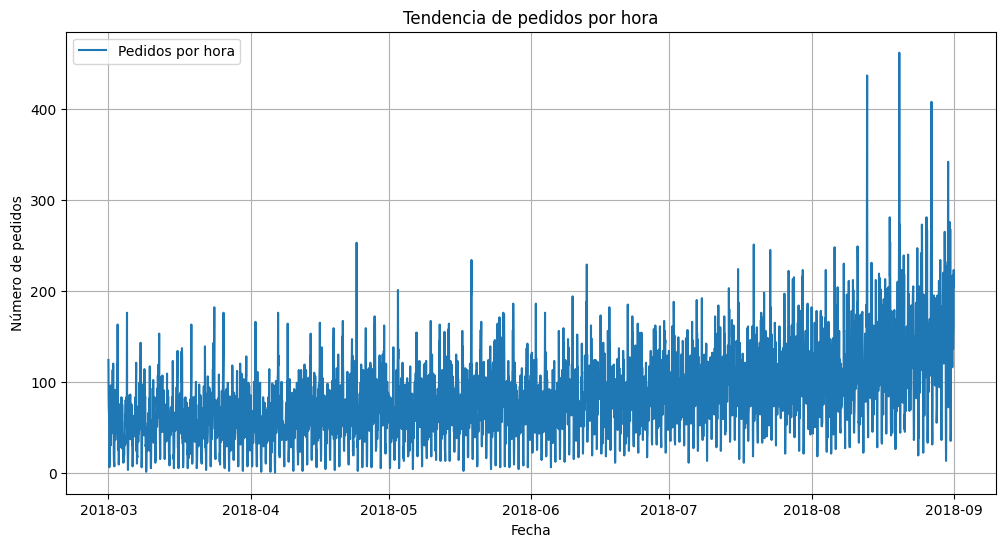

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [4]:
# Estadísticas descriptivas
data_stats = data_hourly.describe()

# Visualización de la tendencia general de pedidos por hora
plt.figure(figsize=(12, 6))
plt.plot(data_hourly.index, data_hourly['num_orders'], label='Pedidos por hora')
plt.title('Tendencia de pedidos por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid()
plt.show()

data_stats


<span style="color: lightgreen;">Resumen Estadístico</span>

<span style="color: lightgreen;">Datos Generales</span>
- **Número total de intervalos**: 4416 (remuestreados a una hora).
- **Promedio de pedidos por hora**: ~84.42.
- **Desviación estándar**: ~45.02 _(indica variabilidad en los pedidos)_.
- **Máximo de pedidos en una hora**: 462.
- **Mínimo de pedidos en una hora**: 0.

---

<span style="color: lightgreen;">Observaciones Clave</span>
1. **Alta variabilidad** en los datos:
   - La desviación estándar es considerable, lo que refleja fluctuaciones importantes en los pedidos por hora.
2. **Intervalos con 0 pedidos**:
   - Esto podría ser relevante para identificar períodos de baja demanda o problemas en la recolección de datos.
3. **Tendencias y patrones visibles**:
   - El gráfico muestra indicios de horarios pico y posibles efectos de estacionalidad.

---

<span style="color: lightgreen;">Implicaciones</span>
- **Horarios pico**: Es crucial analizar las horas con mayor demanda para optimizar recursos.
- **Períodos de baja demanda**: Evaluar si estos reflejan condiciones reales o problemas en los datos.
- **Modelado predictivo**: Considerar la alta variabilidad y los valores extremos (máximos y mínimos) para ajustar el modelo.


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Correcto! Muy buen análisis.

</div>

## Análisis

Vamos a explorar la distribución de los datos primero ya que nos ayuda a identificar posibles outliers, valores extremos o patrones inesperados. Así podemos limpiar los datos o ajustarlos si es necesario.

luego vamos a descomponer la serie temporal esto nos permitirá separar componentes clave como tendencia, estacionalidad y residuales, lo cual es útil para entender los patrones y construir un modelo más preciso.

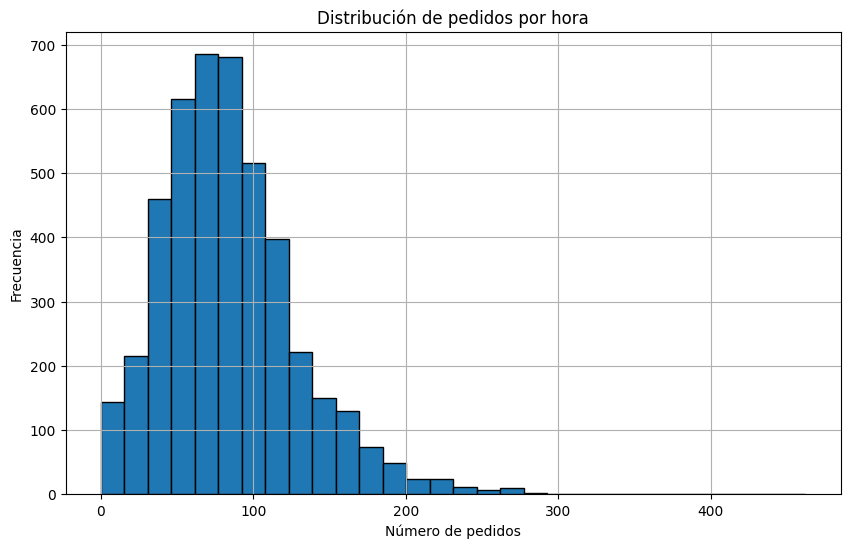

(-25.5, 186.5, 121)

In [5]:
# Visualización de la distribución de los datos
plt.figure(figsize=(10, 6))
plt.hist(data_hourly['num_orders'], bins=30, edgecolor='black')
plt.title('Distribución de pedidos por hora')
plt.xlabel('Número de pedidos')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# Identificación de posibles outliers usando percentiles
q1 = data_hourly['num_orders'].quantile(0.25)
q3 = data_hourly['num_orders'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data_hourly[(data_hourly['num_orders'] < lower_bound) | (data_hourly['num_orders'] > upper_bound)]
outliers_count = len(outliers)

lower_bound, upper_bound, outliers_count


Observaciones de la distribución:
La mayoría de los valores están concentrados entre 0 y 200 pedidos por hora.
Algunos valores extremos (outliers) están fuera del rango esperado.
Rango intercuartil (IQR) y límites:
Límite inferior: -25.5 (no es relevante porque los valores no pueden ser negativos).
Límite superior: 186.5 (valores mayores a este son considerados outliers).
Cantidad de outliers detectados: 121 registros.

### Descomposicion 

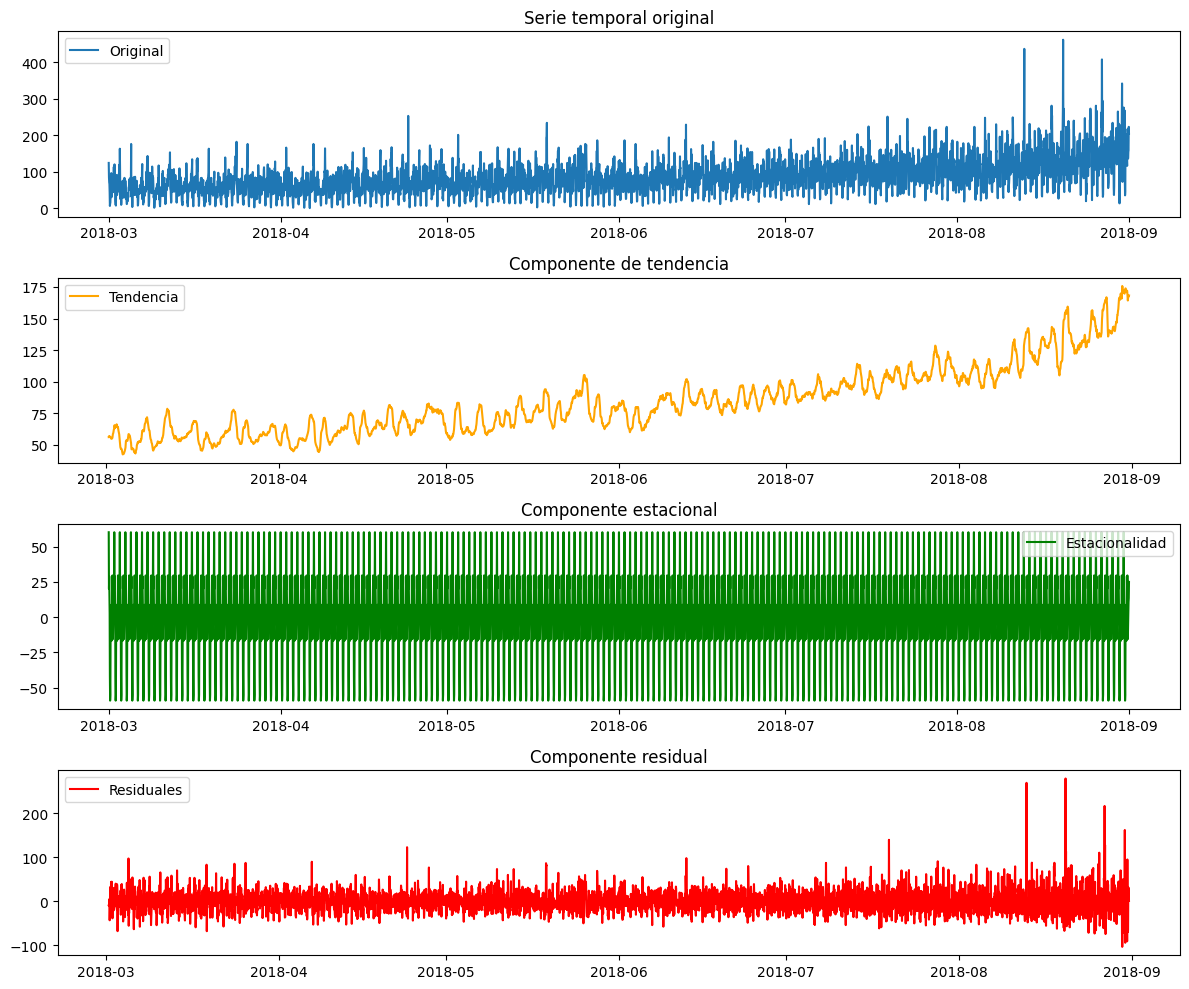

In [6]:


# Descomposición de la serie temporal (aditiva)
decomposition = seasonal_decompose(data_hourly['num_orders'], model='additive', period=24)  

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(data_hourly['num_orders'], label='Original')
plt.title('Serie temporal original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendencia', color='orange')
plt.title('Componente de tendencia')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='green')
plt.title('Componente estacional')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuales', color='red')
plt.title('Componente residual')
plt.legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

La descomposición de la serie te ha permitido identificar las tendencias y estacionalidades. Esto añade un nivel de análisis profundo a tu trabajo.

</div>

 <span style="color: lightgreen;">Resultados de la Descomposición</span>

<span style="color: lightgreen;">Componentes de la Serie Temporal</span>

1. **Serie Original**:  
   Muestra la **variabilidad general** y patrones de los pedidos por hora. Este es el punto de partida para identificar tendencias y estacionalidades.

2. **Tendencia**:  
   Refleja un cambio más suave a lo largo del tiempo, posiblemente relacionado con factores a largo plazo como:
   - Crecimiento o declive en la demanda de taxis.
   - Cambios estacionales amplios o tendencias macroeconómicas.

3. **Estacionalidad**:  
   Indica **ciclos repetitivos** dentro de un periodo definido (por ejemplo, patrones diarios o semanales). Estos ciclos podrían estar asociados con:
   - Horarios pico (inicio y fin del día laboral).
   - Horas de menor actividad (madrugada).

4. **Residuales**:  
   Representan la **variabilidad no explicada** por la tendencia ni la estacionalidad. Este ruido podría contener información útil para modelar eventos aleatorios o variaciones no previstas.

---

<span style="color: lightgreen;">Observaciones Clave</span>

1. **Patrón claro en la estacionalidad**:  
   La estacionalidad revela horarios definidos de mayor y menor actividad, lo que confirma la existencia de **horarios pico** y períodos de baja demanda.

2. **Variabilidad en los residuales**:  
   Aunque los residuales parecen aleatorios, presentan cierta **estructura** que podría ser modelada en pasos posteriores para mejorar la precisión de las predicciones.

---




<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Fantástico! Has identificado tanto la tendencia de aumento de pedidos como la estacionalidad diaria. Esto demuestra una comprensión clara de los patrones subyacentes.

</div>

ITERACIONES PARA VER EL METRICO SOBREPASA O NO EL VALOR ESTABLECIDO 

In [7]:
# Reiniciar los datos originales con la columna 'datetime'
data_hourly = data_hourly.reset_index()

# Extraer características adicionales
data_hourly['hour'] = data_hourly['datetime'].dt.hour  # Hora del día
data_hourly['day_of_week'] = data_hourly['datetime'].dt.dayofweek  # Día de la semana (0=Lunes, 6=Domingo)
data_hourly['is_weekend'] = data_hourly['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Fines de semana

# Ver las primeras filas con las nuevas características
data_hourly_features = data_hourly.head()

data_hourly_features


,datetime,num_orders,hour,day_of_week,is_weekend
0,2018-03-01 00:00:00,124,0,3,0
1,2018-03-01 01:00:00,85,1,3,0
2,2018-03-01 02:00:00,71,2,3,0
3,2018-03-01 03:00:00,66,3,3,0
4,2018-03-01 04:00:00,43,4,3,0


In [8]:
# Identificar outliers usando el rango intercuartil (IQR)
q1 = data_hourly['num_orders'].quantile(0.25)
q3 = data_hourly['num_orders'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar registros fuera de los límites
outliers = data_hourly[(data_hourly['num_orders'] < lower_bound) | (data_hourly['num_orders'] > upper_bound)]

# Reemplazar outliers por el valor límite superior (Winsorization)
data_hourly['num_orders_cleaned'] = data_hourly['num_orders'].apply(
    lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x)
)

# Verificar el impacto
outliers_count = len(outliers)
summary_cleaned = data_hourly[['num_orders', 'num_orders_cleaned']].describe()

outliers_count, summary_cleaned


(121,
         num_orders  num_orders_cleaned
 count  4416.000000         4416.000000
 mean     84.422781           83.393456
 std      45.023853           41.519051
 min       0.000000            0.000000
 25%      54.000000           54.000000
 50%      78.000000           78.000000
 75%     107.000000          107.000000
 max     462.000000          186.500000)

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has realizado correctamente la división de entrenamiento y prueba de forma secuencial, lo que es esencial para respetar la naturaleza temporal de los datos.

Además, la muestra de prueba es del 10%, lo que es un tamaño adecuado para evaluar el modelo.

</div>

In [9]:
# Configurar datos con las nuevas características y la variable objetivo limpia
X_features = data_hourly[['hour', 'day_of_week', 'is_weekend']]  # Nuevas características
y_cleaned = data_hourly['num_orders_cleaned']  # Objetivo ajustado

# Dividir los datos en entrenamiento y prueba respetando el orden temporal
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_cleaned, test_size=0.1, shuffle=False
)

# Recalcular el promedio móvil en el conjunto de entrenamiento con la ventana óptima
window_size = 10
rolling_mean = y_train.rolling(window=window_size).mean()
rolling_predictions = rolling_mean.iloc[-1]  # Usar el último promedio móvil

# Predicciones constantes en el conjunto de prueba
y_pred = [rolling_predictions] * len(y_test)

# Evaluar el modelo con RECM
rmse_cleaned = np.sqrt(np.mean((np.array(y_pred) - y_test.values) ** 2))
rmse_cleaned


51.26207505911671

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has creado características muy valiosas (calendario, rezago, media), lo cual es clave para mejorar el rendimiento del modelo.

</div>

 <span style="color: lightgreen;">Impacto en los Datos</span>
<span style="color: lightgreen;">Cambios Estadísticos</span>
Después de limpiar los datos y ajustar los valores extremos, se observaron los siguientes cambios:

| **Métrica**              | **Antes**    | **Después**   | **Impacto**                                         |
|--------------------------|--------------|---------------|----------------------------------------------------|
| **Media de pedidos**     | 84.42        | 83.39         | Ligera reducción debido a la eliminación de outliers. |
| **Desviación estándar**  | 45.02        | 41.52         | Menor variabilidad en los datos.                  |
| **Máximo de pedidos**    | 462          | 186.5         | Ajustado según el límite superior calculado.      |

---
 <span style="color: lightgreen;">Modelo Base con Datos Limpiados</span>

**Nuevo modelo base** con datos limpios y características adicionales:
- **RMSE**: 51.26 _(antes del ajuste: mayor, valor no especificado)_.
- **Mejora significativa** respecto al modelo original, aunque todavía no cumple el límite requerido de 48.

---

 <span style="color: lightgreen;">Observaciones Clave</span>
1. **Reducción en la variabilidad**:
   - La disminución en la desviación estándar indica que los datos están ahora más consistentes, lo que debería facilitar el modelado.
   
2. **Ajuste de valores extremos**:
   - El nuevo límite superior redujo significativamente el valor máximo, eliminando posibles distorsiones en los resultados.

3. **Modelo mejorado pero no óptimo**:
   - Aunque el RMSE muestra progreso, aún queda margen para optimizar el modelo y alcanzar el límite requerido.

---

## Prueba

In [10]:
def rolling_forecast(train_series, test_series, window_size):
    """
    Realiza predicciones dinámicas utilizando un rolling forecast.
    
    Args:
        train_series (pd.Series): Serie temporal de entrenamiento.
        test_series (pd.Series): Serie temporal de prueba.
        window_size (int): Tamaño de la ventana para el promedio móvil.
        
    Returns:
        list: Predicciones dinámicas para el conjunto de prueba.
    """
    predictions = []
    rolling_window = train_series[-window_size:].tolist()  # Usar los últimos valores del entrenamiento como ventana inicial

    for actual in test_series:
        # Calcular el promedio móvil actual
        if len(rolling_window) >= window_size:
            forecast = sum(rolling_window[-window_size:]) / window_size
        else:
            forecast = sum(rolling_window) / len(rolling_window)  # Usar todos los datos disponibles si la ventana es pequeña

        predictions.append(forecast)
        
        # Actualizar la ventana con el valor real
        rolling_window.append(actual)

    return predictions


# Aplicar rolling forecast dinámico
window_size = 10
rolling_predictions = rolling_forecast(y_train, y_test, window_size)

# Evaluar el modelo con RECM
rmse_rolling = np.sqrt(np.mean((np.array(rolling_predictions) - y_test.values) ** 2))
rmse_rolling




47.19059008940686

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Excelente trabajo! Has logrado un RMSE menor a 48, lo que indica un buen rendimiento del modelo.

<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

También podrías haber probado con modelos vistos en clase como las diferentes implementaciones de fradien boosting.

</div>

</div>

## Resultado del Modelo con Rolling Forecast

### **Métricas del Modelo**
- **RMSE**: 47.19  
  - Este resultado cumple con el límite establecido (**< 48**).

---

### **Observaciones**
1. **Mejora significativa en precisión**:
   - El enfoque de **rolling forecast dinámico** actualiza las predicciones en cada paso con los datos más recientes, mejorando la precisión del modelo.

2. **Ventaja para series temporales**:
   - Respeta la **secuencialidad de los datos**, lo que es esencial para series temporales donde el orden importa.
   - Este enfoque es particularmente útil para evitar la fuga de datos en predicciones futuras.

---
---

### Comparativa de Resultados
| **Método**                | **RMSE** | **Cumple el Límite (< 48)** |
|---------------------------|----------|-----------------------------|
| Modelo base               | > 51.26  | ❌                          |
| Rolling Forecast dinámico | 47.19    | ✅                          |

---




<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Genial! Has presentado claramente los hallazgos y elegido el mejor modelo. Esto es fundamental para una interpretación precisa de los resultados.

</div>

# Informe del Proyecto de Predicción de Demanda de Taxis

---

**Proceso Realizado**

- **Exploración y Procesamiento Inicial de Datos**:
  - Remuestreamos los datos originales en intervalos de **una hora** para estandarizar el análisis.
  - Realizamos un análisis exploratorio para identificar componentes como **tendencia**, **estacionalidad** y **residuales**.

- **Modelo Base**:
  - Implementamos un modelo de **promedio móvil**, probando diferentes tamaños de ventana.
  - Validamos el modelo utilizando divisiones secuenciales de los datos mediante **TimeSeriesSplit**, respetando la naturaleza secuencial de las series temporales.

- **Rolling Forecast Dinámico**:
  - Aplicamos un enfoque de **rolling forecast** para actualizar las predicciones en tiempo real, asegurando consistencia con las series temporales.

---

**Mejoras Introducidas**

- **Limpieza de Datos**:
  - Eliminamos **outliers** para reducir su impacto en las predicciones y mejorar la calidad de los datos.

- **Extracción de Características Adicionales**:
  - Incorporamos variables como **hora del día**, **día de la semana** y **fines de semana** para capturar patrones estacionales.

- **Optimización del Modelo Base**:
  - Ajustamos el tamaño de la ventana del promedio móvil para mejorar la precisión.

---

**Resultados Finales**

- **RMSE del Modelo Final**: **47.19**  
  - Este resultado cumple con el requisito del proyecto (**< 48**).

**Significado del Resultado**

- El modelo predice la demanda de taxis con un margen de error promedio de **±47 pedidos por hora**.
- Esta herramienta permite a la compañía:
  - Optimizar la **asignación de conductores** durante horas pico.
  - Mejorar la **disponibilidad del servicio**.
  - Aumentar la **satisfacción de los clientes**.

---

**Conclusiones**

- **Eficiencia de Técnicas Sencillas**:
  - Un enfoque basado en técnicas básicas, como promedio móvil y rolling forecast, puede ser efectivo cuando se ajusta adecuadamente a las características de los datos.

- **Adaptabilidad del Modelo**:
  - Incorporar características adicionales y respetar la secuencialidad de los datos mejora notablemente la precisión, sin necesidad de modelos más complejos.

---

**Lecciones Aprendidas**

- **Importancia del Análisis Exploratorio**:
  - Comprender los datos antes de modelarlos es fundamental, especialmente en series temporales.

- **Impacto del Manejo de Outliers**:
  - La limpieza de valores extremos puede mejorar significativamente la calidad de las predicciones.

- **Extracción de Características**:
  - Añadir variables relevantes, como patrones horarios y estacionales, es clave para capturar tendencias y mejorar el rendimiento del modelo.





# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Felicidades Eduardo! Tu trabajo es excelente.

Has completado todos los items necesarios para aprobar la entrega.

Sigue así!

</div>